# Práctica 2: Clasificador Bayesiano
## Gabriel Daniel Aguilar Luna, Zuriel Uzai Rodrígez Agiss
### _Facultad de Ingenierría, Universidad Nacional Autónoma de México_
### _Ciudad de México, México_
#### gabriel.aguilar@ingenieria.unam.edu,  zurieluzai2015@gmail.com

***

### __1. Objetivos__

Clasificar imágenes con 2, 3 o 4 regiones utilizando el clasificador de Bayes.

***

### __2. Introducción__


### Clasificador de Bayes

Un clasificador Naive Bayes es un modelo probabilístico de aprendizaje automático que se utiliza para la tarea de clasificación. El fundamento del clasificador se basa en el teorema de Bayes.

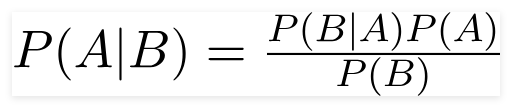

Utilizando el teorema de Bayes, podemos encontrar la probabilidad de que ocurra A, dado que ocurrió B. Aquí, B es la evidencia y A es la hipótesis. La suposición que se hace aquí es que los predictores / características son independientes. Que la presencia de una característica en particular no afecte a la otra. De ahí que se le llame ingenuo.

Para su aplicación se debe e reescribir el Teorema de Bayes como a continuación 

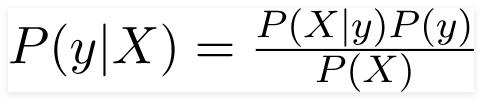
La variable y es la variable de clase (jugar golf, ser una flor), que representa si se pertenece o no a la clase dadas las condiciones. La variable X representa los parámetros/características.
X se da como,
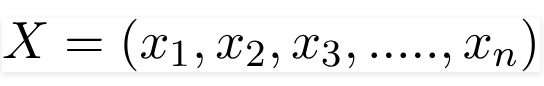

Aquí x_1, x_2… .x_n representan las características, es decir, se pueden asignar a la perspectiva, la temperatura, la humedad y el viento. Sustituyendo X y expandiendo usando la regla de la cadena obtenemos,
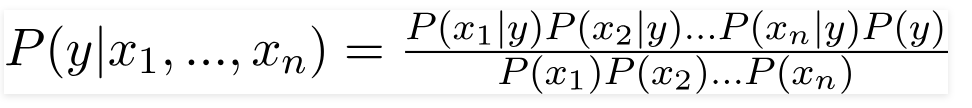

Ahora, puede obtener los valores para cada uno mirando el conjunto de datos y sustituirlos en la ecuación. Para todas las entradas del conjunto de datos, el denominador no cambia, permanece estático. Por tanto, se puede eliminar el denominador y se puede introducir una proporcionalidad.
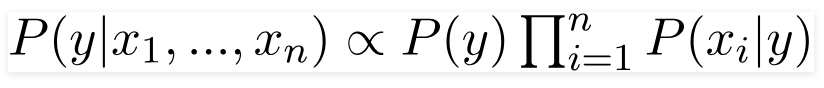

En nuestro caso, la variable de clase (y) tiene solo dos resultados, sí o no. Puede haber casos en los que la clasificación sea multivariante. Por lo tanto, necesitamos encontrar la clase y con máxima probabilidad.
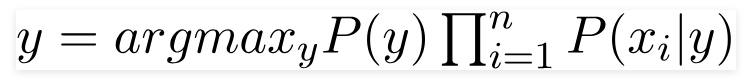

#### Tipos de clasificador Bayes ingenuo:
##### Bayes ingenuo multinomial:
Esto se usa principalmente para problemas de clasificación de documentos, es decir, si un documento pertenece a la categoría de deportes, política, tecnología, etc. Las características / predictores utilizados por el clasificador son la frecuencia de las palabras presentes en el documento.

##### Bernoulli ingenuo Bayes:
Esto es similar a los bayes ingenuos multinomiales, pero los predictores son variables booleanas. Los parámetros que usamos para predecir la variable de clase toman solo valores sí o no, por ejemplo si una palabra aparece en el texto o no.

##### Bayes ingenuo gaussiano:
Cuando los predictores toman un valor continuo y no son discretos, asumimos que estos valores se muestrean a partir de una distribución gaussiana.

Dado que la forma en que los valores están presentes en el conjunto de datos cambia, la fórmula para la probabilidad condicional cambia a,

***

### __3. Desarrollo__

##### Imports y funciones

In [2]:
import matplotlib.pyplot as plt
import cv2
import skimage as ski
import PIL as pil
import imageio as io
import numpy as np
from PIL import Image, ImageFilter
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch
from math import log

# Esta funcion 'desdobla' cadenas para crear un rango y un numero
# eg: '100'=mayores que 100, '0-50'= entre 0 y 50, '10-20,500'= entre 10 y 20 o mayores de 500
def listRanger(rango: str):
    # Separa la cadena por comas
    rango = rango.split(',')
    # Definicion de las variables de retorno
    listarango = []
    mayorq = -1
    # Recorre las sentencias separadas anteriormente
    for x in rango:
        # Si la sentencia tiene un '-' es un rango
        if '-' in x:
            # Los rangos se añaden a la lista listarango
            listax = x.split('-')
            listarango += list(range(int(listax[0]),int(listax[1])))
        # Si no, es una cota inferior
        else:
            # Solo puede existir una de estas cotas en la sentencia
            mayorq = int(x)

    return [listarango, mayorq]

# Esta función imprime la imagen junto con las curvas de la posición nColl de contornos
# Que cumplan con range y retorna un arreglo con dichas curvas.
# Se puede especificar los puntos en el perimetro de las lineas con range. eg: range='400-560'
# Si no se especifica se utiliza '150'
# Se puede especificar un nombre para guardar la imagen resultante con save. eg: save='imagen2.png'
# Si no se especifica se utiliza 'ImCrTMP.png'
# eg: masker.printImCr(fruta, fruta_contornos, 1, range='200', save='comida_contornos.png')
def printImCr(imagen, contornos, nColl, **kwargs):
    # Desdobla range
    rangolstd = listRanger(kwargs["range"] if ("range" in kwargs) else '150')
    # Define variable de retorno
    curvas_array = []
    # Con este for se muestran todas las lineas cuya primera dimension entre en el rango
    for i in contornos.collections[nColl].get_paths():
        # Si cumple con las caracteristicas indicadas en range se añade al plot y a la var de retorno
        if len(i.vertices) in rangolstd[0] or ((len(i.vertices) > rangolstd[1]) if (rangolstd[1] != -1) else (len(i.vertices) > len(i.vertices)+1)):
            plt.plot(i.vertices[:,0], i.vertices[:,1], '--b')
            curvas_array.append(i.vertices)
    # Muestra la imagen
    plt.imshow(imagen)
    plt.axis('off')
    # Salva la imagen
    plt.savefig('resultados/'+kwargs["save"] if ("save" in kwargs) else 'resultados/ImCrTMP.png', bbox_inches='tight', transparent=False, pad_inches = 0)
    # Regresa el arreglo
    return curvas_array

# Esta función imprime la imagen de fondo junto con los poligonos
# Definidos por las curvas en curvas_arr
# Retorna un obj Multipolygon
def printImPoly(curvas_arr, fondo):
    # Arreglo aux
    poly_array = []
    # Recorre arreglo de curvas
    for crvua in curvas_arr:
        x = crvua[:,0]
        y = crvua[:,1]
        poly_array.append(Polygon([(i[0], i[1]) for i in zip(x,y)]))
    polygons = MultiPolygon(poly_array)
    #len(polygons.geoms)
    #polygons
    fig = plt.figure() 
    ax = fig.gca()

    # Plotea la imagen de fondo
    plt.imshow(fondo)
    # Plotea los poligonos
    for poly in polygons:
        ax.add_patch(PolygonPatch(poly))
    #ax.axis('scaled')
    plt.show()
    # Retorna los poligonos
    return polygons

def listaclase(clase, n=4):
    clase_array = []
    for i in range(n):
        objeto = io.imread('entrenamiento-procesado/Entrenamiento'+str(i+1)+'-'+ clase +'_gaussianBlur.jpg')
        clase_array.append(np.array(objeto))
        plt.imshow(objeto)
        plt.show()
    return clase_array

def pixelsMatrix(clase, n=4):
    lista_clase = listaclase(clase, n)
    pixeles_clase = []
    for objeto in lista_clase:
        for renglon in objeto:
            for pixel in renglon:
                if pixel.mean() > 0.:
                    pixeles_clase.append(pixel)
    return np.array(pixeles_clase)

def pixelsMatrix_blanco(clase, n=6):
    lista_clase = listaclase(clase, n)
    pixeles_clase = []
    pixeles_probados = 0
    for objeto in lista_clase:
        for renglon in objeto:
            for pixel in renglon:
                pixeles_probados += 1
                if pixel.mean() < 250.:
                    pixeles_clase.append(pixel)
    return np.array(pixeles_clase), pixeles_probados

def getSigma(matriz_pix):
    MU = np.mean(matriz_pix, axis=0)
    SIGMA = np.zeros((len(MU),len(MU)))

    for pixel in matriz_pix:
        P_MU = np.array([pixel-MU])
        SIGMA += np.dot(np.transpose(P_MU),P_MU)
    
    return SIGMA / len(matriz_pix)

def probaClase(lenClase, x, y, n):
    return lenClase/(x*y*n)

def ladoDerecho(SIGMA_det, probaClase):
    return (-log(SIGMA_det)/2) + log(probaClase)

def probaPixClase(pixel, MU, SIGMA_inv):
    P_MU = np.array([pixel-MU])
    #print((np.dot(np.dot(P_MU,SIGMA_inv), np.transpose(P_MU))[0,0])/-2)
    return (np.dot(np.dot(P_MU,SIGMA_inv), np.transpose(P_MU))[0,0])/-2

def clasificador(nombre_imagen, MUs, SIGMAs_inv, ldDers, colores):
    prueba_img = io.imread(nombre_imagen)
    prueba = np.array(prueba_img)
    plt.imshow(prueba_img)
    plt.show()
    
    resultado = np.zeros(prueba.shape, dtype=int)
    for i in range(len(prueba)):
        for j in range(len(prueba[i])):
            arr_aux = []
            for n in range(len(MUs)):
                arr_aux.append(probaPixClase(prueba[i][j], MUs[n], SIGMAs_inv[n])+ldDers[n])
            resultado[i][j]= colores[arr_aux.index(max(arr_aux))]
    return resultado

def makeGaussian(nombre_imagen, valor_radio = 3):        
    #codigo de internet para aplicar filtro Gaussiano xd
    #Abriendo imagen con Image
    image = Image.open(nombre_imagen)

    #Aplicando el filtro de Gaussiano
    #Con un valor para el radio igual a 3
    image = image.filter(ImageFilter.GaussianBlur(radius = valor_radio))

    #Se muestra la imagen
    image.show()

    #Se gurada esta nueva imagen borrosa
    #image.save(nombre_imagen[:-4]+"_gaussianBlur.jpg")

#### __3.1 Realizar preprocesamiento de sus imágenes con un filtro gaussiano__

##### Esta función genera imagenes con filtro Gaussiano 

In [3]:
#makeGaussian('comida/Entrenamiento1.jpg')

#### __3.2 Seleccionar sus imágenes con zonas aledañas a clasificar, verifique que tenga regiones contiguas__
#### __3.3 Genere sus propias máscaras de análisis para que sólo se quede con información de cada zona__ 
#### __3.4 Implementar un clasificador bayesiano, obteniendo información a priori de las imágenes para las diferentes regiones de imagen__

##### A continuación se muestran las imagenes con mascara:

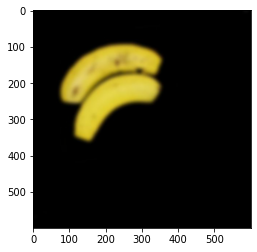

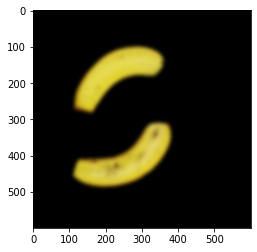

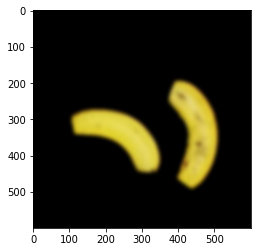

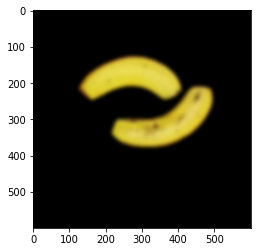

In [4]:
matriz_platanos = pixelsMatrix('platanos')

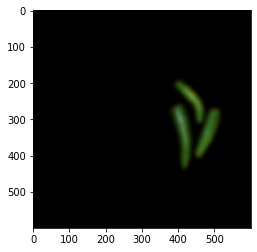

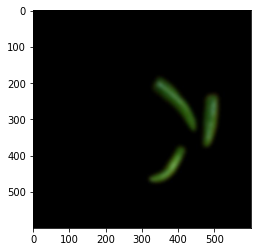

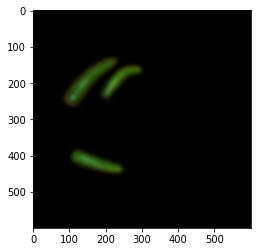

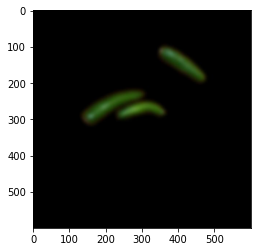

In [5]:
matriz_chiles = pixelsMatrix('chiles')

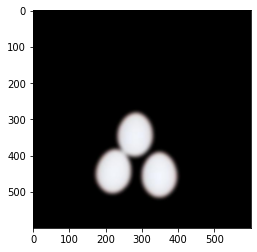

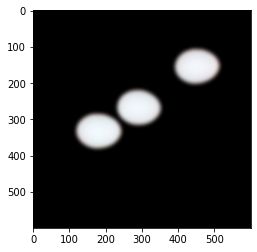

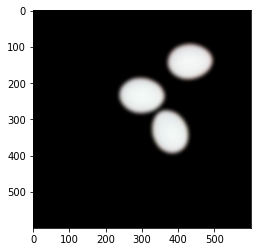

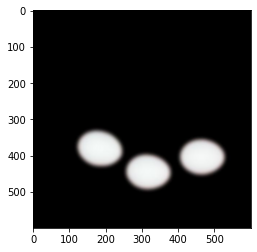

In [6]:
matriz_huevos = pixelsMatrix('huevos')

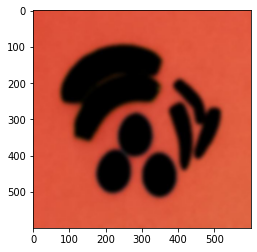

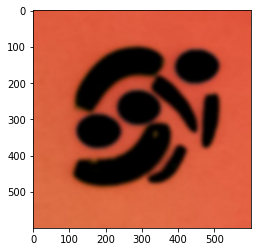

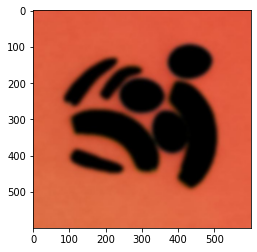

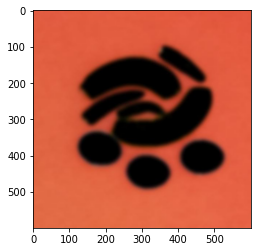

In [7]:
matriz_fondos = pixelsMatrix('fondos')

#### __3.5 Desplegar en cada fase las imágenes y cálculos intermedios que apoyen el proceso, por ejemplo: cálculo de probabilidad de la región1, región 2, … hasta la región n. Mostrar los resultados también para el cálculo de la media, matriz de covarianza etc.__
#### __3.6 Una vez obtenido estos valores. clasificar los pixeles de la imagen con base en las probabilidades a priori obtenidas utilizando la aproximación gaussiana en la fórmula de Bayes(no olvide calcular la media, la matriz de covarianza y los cálculos necesarios para la clasificación)__

##### Calculos y definicion de variables utiles:

In [14]:
MU_plt = np.mean(matriz_platanos, axis=0)
MU_chl = np.mean(matriz_chiles, axis=0)
MU_hvs = np.mean(matriz_huevos, axis=0)
MU_f = np.mean(matriz_fondos, axis=0)
MUs_comida = [MU_plt, MU_chl, MU_hvs, MU_f]
MUs_comida

[array([144.86781065, 129.97474931,  39.56449182]),
 array([27.49149605, 44.55537392, 11.81076929]),
 array([151.73348153, 150.91414429, 151.58632995]),
 array([188.77904517,  78.98711576,  53.5724968 ])]

In [9]:
SIGMA_plt = getSigma(matriz_platanos)
SIGMA_chl = getSigma(matriz_chiles)
SIGMA_hvs = getSigma(matriz_huevos)
SIGMA_f = getSigma(matriz_fondos)
SIGMAs_comida = [SIGMA_plt, SIGMA_chl, SIGMA_hvs, SIGMA_f]
SIGMAs_comida

[array([[7952.46639966, 7369.52241323, 2400.47254147],
        [7369.52241323, 6861.86945079, 2258.762418  ],
        [2400.47254147, 2258.762418  ,  865.64896598]]),
 array([[ 478.81552957,  824.6835157 ,  283.60090267],
        [ 824.6835157 , 1510.10111603,  511.39931969],
        [ 283.60090267,  511.39931969,  230.24787702]]),
 array([[8762.15259112, 8923.72160776, 9014.22178439],
        [8923.72160776, 9105.36636168, 9198.26493459],
        [9014.22178439, 9198.26493459, 9298.05089381]]),
 array([[5155.92713409, 2163.26281371, 1501.25037281],
        [2163.26281371,  953.913919  ,  648.02718693],
        [1501.25037281,  648.02718693,  452.25270504]])]

In [10]:
SIGMA_plt_inv = np.linalg.inv(SIGMA_plt)
SIGMA_chl_inv = np.linalg.inv(SIGMA_chl)
SIGMA_hvs_inv = np.linalg.inv(SIGMA_hvs)
SIGMA_f_inv = np.linalg.inv(SIGMA_f)
SIGMAs_inv_comida = [SIGMA_plt_inv, SIGMA_chl_inv, SIGMA_hvs_inv, SIGMA_f_inv]
SIGMAs_inv_comida

[array([[ 0.03081459, -0.03520383,  0.00640851],
        [-0.03520383,  0.04125132, -0.01001688],
        [ 0.00640851, -0.01001688,  0.00952153]]),
 array([[ 0.03556267, -0.01850942, -0.0026923 ],
        [-0.01850942,  0.01230574, -0.00453362],
        [-0.0026923 , -0.00453362,  0.01772884]]),
 array([[ 0.06096804, -0.06540462,  0.00559575],
        [-0.06540462,  0.242089  , -0.17608282],
        [ 0.00559575, -0.17608282,  0.16887573]]),
 array([[ 0.00599793, -0.00287083, -0.01579653],
        [-0.00287083,  0.04080012, -0.04893226],
        [-0.01579653, -0.04893226,  0.12476208]])]

In [11]:
probaPlatanos = probaClase(len(matriz_platanos), 600, 600, 4)
probaChiles = probaClase(len(matriz_chiles), 600, 600, 4)
probaHuevos = probaClase(len(matriz_huevos), 600, 600, 4)
probaFondos = probaClase(len(matriz_fondos), 600, 600, 4)
probasComida = [probaPlatanos, probaChiles, probaHuevos, probaFondos]
probasComida

[0.18110069444444443,
 0.07774166666666667,
 0.11714583333333334,
 0.8895986111111112]

In [12]:
ldDer_plt = ladoDerecho(np.linalg.det(SIGMA_plt), probaPlatanos)
ldDer_chl = ladoDerecho(np.linalg.det(SIGMA_chl), probaChiles)
ldDer_hvs = ladoDerecho(np.linalg.det(SIGMA_hvs), probaHuevos)
ldDer_f = ladoDerecho(np.linalg.det(SIGMA_f), probaFondos)
ldDers_comida = [ldDer_plt, ldDer_chl, ldDer_hvs, ldDer_f]
ldDers_comida

[-10.267949936509723,
 -9.904622237090496,
 -8.992167045882638,
 -7.34893993836054]

In [12]:
colores_comida = [[206, 184, 56], [48,77,20], [224,222,223], [100,100,100]]

#### __3.7 Cree una nueva imagen con las clases resultantes y asigne diferentes valores de gris para cada región__

##### Implementación del Clasificador:

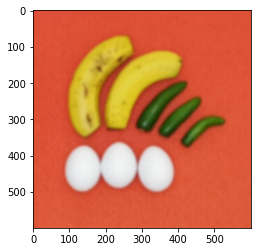

In [13]:
resultado1 = clasificador('comida/Prueba1_gaussianBlur.jpg', MUs_comida, SIGMAs_inv_comida, ldDers_comida, colores_comida)

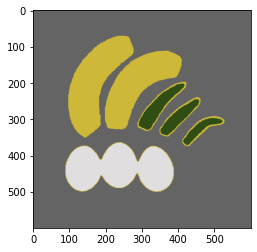

In [14]:
plt.imshow(resultado1)
plt.show()

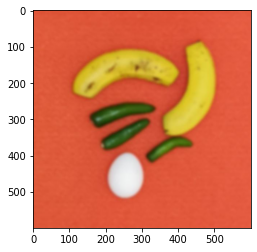

In [15]:
resultado2 = clasificador('comida/Prueba2_gaussianBlur.jpg', MUs_comida, SIGMAs_inv_comida, ldDers_comida, colores_comida)

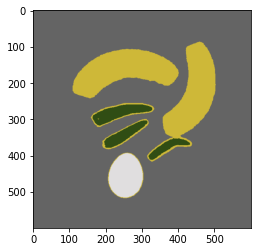

In [16]:
plt.imshow(resultado2)
plt.show()

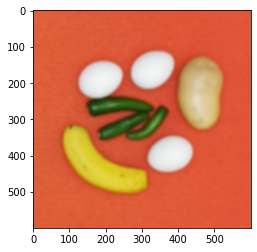

In [17]:
resultado3 = clasificador('comida/Prueba3_gaussianBlur.jpg', MUs_comida, SIGMAs_inv_comida, ldDers_comida, colores_comida)

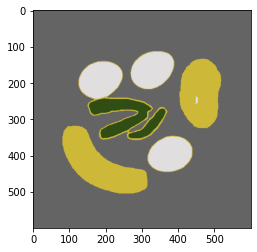

In [18]:
plt.imshow(resultado3)
plt.show()

##### A continuación se muestran las imagenes con mascara para los monos:

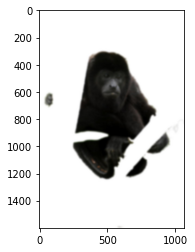

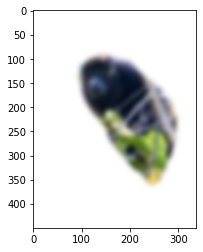

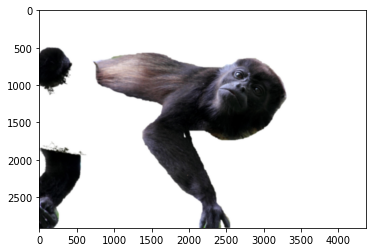

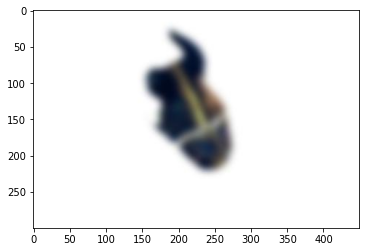

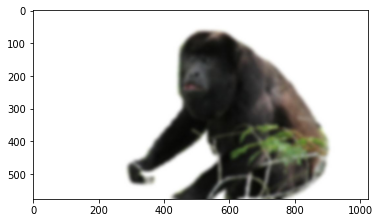

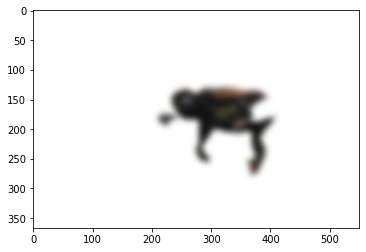

In [19]:
matriz_monos, pixeles_probados_monos = pixelsMatrix_blanco('monos')

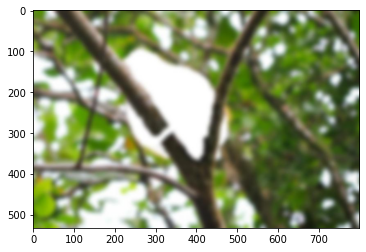

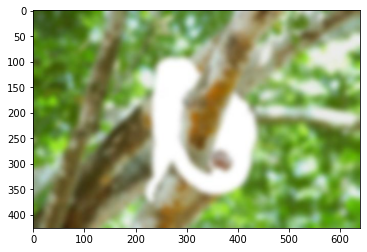

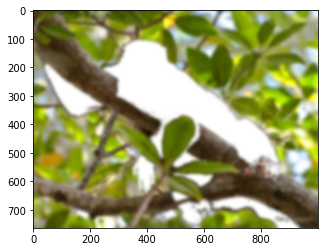

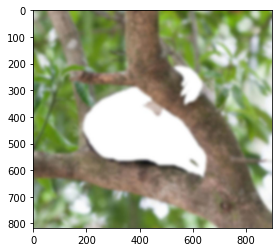

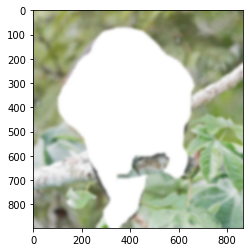

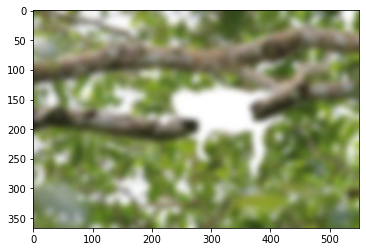

In [20]:
matriz_fondos_monos, pixeles_probados_monosf = pixelsMatrix_blanco('monos-fondo')

##### Calculos y definicion de variables utiles para monos:

In [21]:
MU_mns = np.mean(matriz_monos, axis=0)
MU_mf = np.mean(matriz_fondos_monos, axis=0)
MUs_monos = [MU_mns, MU_mf]
MUs_monos

[array([63.56260292, 61.07714812, 63.52694722]),
 array([135.46457887, 144.80248188,  98.40324795])]

In [22]:
SIGMA_mns = getSigma(matriz_monos)
SIGMA_mf = getSigma(matriz_fondos_monos)
SIGMAs_monos = [SIGMA_mns, SIGMA_mf]
SIGMAs_monos

[array([[4107.88600451, 3906.7790573 , 3974.11803401],
        [3906.7790573 , 3756.61212686, 3812.61123856],
        [3974.11803401, 3812.61123856, 3950.30081667]]),
 array([[2030.50653471, 1926.23332319, 2426.49187297],
        [1926.23332319, 2181.58865692, 2269.89120568],
        [2426.49187297, 2269.89120568, 3829.72163239]])]

In [23]:
SIGMA_mns_inv = np.linalg.inv(SIGMA_mns)
SIGMA_mf_inv = np.linalg.inv(SIGMA_mf)
SIGMAs_inv_monos = [SIGMA_mns_inv, SIGMA_mf_inv]
SIGMAs_inv_monos

[array([[ 0.02277242, -0.02108119, -0.00256333],
        [-0.02108119,  0.03252094, -0.01017912],
        [-0.00256333, -0.01017912,  0.01265625]]),
 array([[ 4.80176254e-03, -2.80246258e-03, -1.38134129e-03],
        [-2.80246258e-03,  2.83147152e-03,  9.74014290e-05],
        [-1.38134129e-03,  9.74014290e-05,  1.07859609e-03]])]

In [24]:
probaMonos = len(matriz_monos)/pixeles_probados_monos
probaFondosMonos = len(matriz_fondos_monos)/pixeles_probados_monosf
probasMonos = [probaMonos, probaFondosMonos]
probasMonos

[0.25838725997296746, 0.8459134800253663]

In [25]:
ldDer_mns = ladoDerecho(np.linalg.det(SIGMA_mns), probaMonos)
ldDer_mf = ladoDerecho(np.linalg.det(SIGMA_mf), probaFondosMonos)
ldDers_monos = [ldDer_mns, ldDer_mf]
ldDers_monos

[-9.556367757280018, -10.326440967703114]

In [26]:
colores_monos = [[10, 10, 10], [10,150,20]]

##### Implementación del Clasificador para monos:

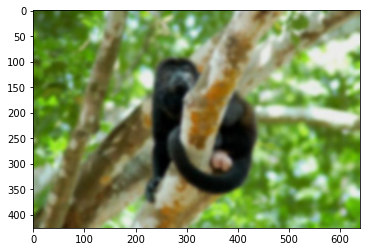

In [27]:
resultado1_M = clasificador('monos/n0116_gaussianBlur.jpg', MUs_monos, SIGMAs_inv_monos, ldDers_monos, colores_monos)

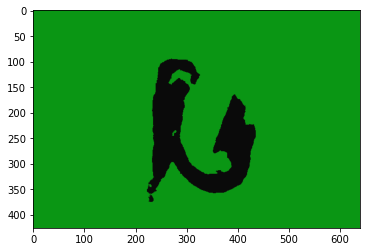

In [28]:
plt.imshow(resultado1_M)
plt.show()

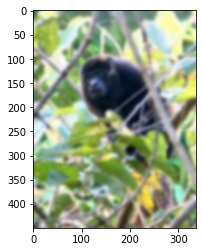

In [29]:
resultado2_M = clasificador('monos/n0020_gaussianBlur.jpg', MUs_monos, SIGMAs_inv_monos, ldDers_monos, colores_monos)

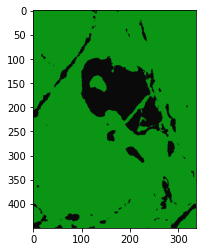

In [30]:
plt.imshow(resultado2_M)
plt.show()

### Conclusiones

Al haber implementado un clasificador de Bayes para la clasificación de 2 o más imágenes nos dimos cuenta de que con la aplicación directa de la regla de Bayes da como resultado una problema computacionalmente costoso que no hace más que incrementarse conforme la cantidad de imágenes de entrenamiento y la complejidad aumenta. Por tante, si bien es un buen punto de partida, no es un clasificador óptimo.




### Referencias:

- (s.a) (s.f) _matplotlib.pyplot.plot_ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

- (s.a) (s.f) _matplotlib.contour.QuadContourSet_ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/contour_api.html#matplotlib.contour.QuadContourSet

- (s.a) (s.f) _matplotlib.image.AxesImage_ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/image_api.html#matplotlib.image.AxesImage

- (s.a) (s.f) _matplotlib.pyplot.imshow_ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

- (s.a) (s.f) _matplotlib.patches.Patch._ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

- (s.a) (s.f) Shapely and geometric objects. Consultado de https://automating-gis-processes.github.io/site/notebooks/L1/geometric-objects.html

- (s.a) (s.f) _matplotlib.path._ Documentación de Matplotlib. Consultado de https://matplotlib.org/stable/api/path_api.html

- (s.a) (s.f) _matplotlib.pyplot.plot._ Documentación de Matplotlib. Consultado de https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

- (s.a) (s.f) Image Resolution and DPI. Consultado de https://largeprinting.com/resources/image-resolution-and-dpi.html

- (s.a)(26 de dic, 2020) Apply a Gauss filter to an image with Python. Geeks for Geeks. Consultado de
https://www.geeksforgeeks.org/apply-a-gauss-filter-to-an-image-with-python/

- (s.a) (14 de julio, 2019) _Python PIL | GaussianBlur() method._ Geeks for Geeks. Consultado de https://www.geeksforgeeks.org/python-pil-gaussianblur-method/

- gene (13 de abril, 2017) _Geopandas Polygon to matplotlib patches Polygon conversion_ Stack Exchange. Consultado de https://gis.stackexchange.com/questions/197945/geopandas-polygon-to-matplotlib-patches-polygon-conversion

- gene (4 de junio, 2014). _Converting Matplotlib contour objects to Shapely objects._ Stack Overflow. Consultado de https://gis.stackexchange.com/questions/99917/converting-matplotlib-contour-objects-to-shapely-objects

- Gillies, S.(27 de sep, 2020) _The Shapely User Manual._ Shapely. Consultado de https://shapely.readthedocs.io/en/stable/manual.html

- jodag. (6 de mayo, 2020) _Matplotlib - unable to save image in same resolution as original image._ Stack Overflow. Consultado de https://stackoverflow.com/questions/34768717/matplotlib-unable-to-save-image-in-same-resolution-as-original-image#34769840

- Ghandi, R. (5 de Mayo, 2018) _Naive Bayes Classifier_ Towards Data Science. Consultado de https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c

- tom10 (23 de Marzo, 2015) Python - convert contours to image. Stack Overflow. Consultado de
https://stackoverflow.com/questions/29213238/python-convert-contours-to-image#29214175

